# RFSoC Spectrum Analyser Module (RFSoC SAM)
> This notebook presents a flexible hardware accelerated Spectrum Analyser Module for the Zynq UltraScale+ RFSoC. The steps outlined in the Table of Contents below will showcase the features and flexibility of the Spectrum Analyser and detail the underlying FPGA architecture. <br><br>
The Spectrum Analyser Module was developed by the University of Strathclyde. At this point in time, the analyser is capable of 256MHz of bandwidth and can achieve 7.8125KHz of frequency resolution. The bandwidth is entirely adjustable between 0MHz and 256MHz, and the architecture supports several windowing coefficients including user defined windows. FPGA floating-point arithmetic is also exploited to accurately implement hardware accelerated Power Spectral Density (PSD) calculations, including decibel conversion for power analysis. Plotting and animating the Spectrum is achieved using the [Plotly](https://plot.ly/) libraries. The Plotly library allows the spectrum to be visualised in two different ways; PSD frame plots and a Waterfall Plot (Spectogram). <br><br>
It is recommended that you follow the notebook in order starting with [Overview](#overview).<br><br>
<b>Table of Contents</b>
1. [Overview](#overview)
2. [Import Libraries](#import_libraries)
3. [The Transmitter](#transmitter)
4. [Bandwidth Adaptation](#bandwidth_adaptation)
5. [Window Selection](#window_selection)
6. [The Receiver](#receiver)
7. [Spectrum Analysis](#spectrum_analysis) <br>
    7.1. [FFT Viewer](#fft_viewer) <br>
    7.2. [Waterfall Plot (Spectogram)](#waterfall_plot) <br>
8. [Summary](#summary)
<br><br>
<div style="background-color: #d9edf7; color: #31708f; padding: 15px;">
    <b>Tip:</b> Make sure you have the SMA loopback cable plugged in as detailed in the <a href="https://github.com/Xilinx/PYNQ_RFSOC_Workshop">instructions here</a>.
</div>

<a class="anchor" id="overview"></a>
## 1. Overview
The Zynq RFSoC contains several Analogue-to-Digital Converters (ADCs) and Digital-to-Analogue Converters (DACs) that allow us to communicate with the analogue world (we refer to these as data converters). The Spectrum Analyser Module uses the RFSoC's ADC to receive Radio Frequency (RF) data, and subsequently manipulate it to create an RF spectrum. As shown in the figure below, this system leverages the RFSoC's data converters, Programmable Logic (PL), and Processing System (PS) to visualise the RF Spectrum. Furthermore, this example also uses a transmitter so that there is a signal to inspect in the frequency domain. Only one DAC (Tile 1, Channel 2) will be used in this design. Three ADCs are leveraged and a switch, implemented in the PL, allows the user to select the relevant converter. For the purposes of this notebook and corresponding Voila dashboard the ADCs are referred to as ADC0, ADC1 and ADC2.

`ADC0:` Tile 0, Channel 0<br>
`ADC1:` Tile 0, Channel 1<br>
`ADC2:` Tile 1, Channel 0

The design applies an array of techniques such as low-pass filtering, windowing, and a Fast-Fourier-Transform (FFT) to compute the RF spectrum. A significant portion of the design has been implemented in the RFSoC's PL to relieve the PS of highly computational arithmetic. Furthermore, as the RF data is streaming into the PL, the Field Programmable Gate Array (FPGA) logic fabric is better suited to manipulating the data in real-time. To keep the design as simple as possible, each block in the Spectrum Analyser Module (and the transmitter block) can be configured or used with a single function. These functions will be required later in this notebook and are detailed below:

* <b>`SAM.TransmitterSetup()`</b> - Sets the modulation scheme and transmit frequency of the transmit signal.
* <b>`SAM.WindowSetup()`</b> - Creates an interface for the user to load predefined window coefficients. Available windows include Bartlett, Blackman, Hamming, Hanning and Rectangular.
* <b>`SAM.ReceiverSetup()`</b> - Sets the center frequency for receiving data, the resolution of the signal inspected, and which ADC to receive data from.
* <b>`SAM.SpectrumViewer()`</b> - Creates an animated plot of the FFT data from hardware as well as an animated time domain plot of the FFT data from hardware (using a heatmap).

As shown in the figure below, there are several Direct Memory Access (DMA) cores. These are used to transfer data between the RFSoC's PS and PL with minimal support from the Arm-Cortex A53 processors. For example, the bandwidth selector uses a DMA to change its low-pass filter coeffiecents on the fly. Similarly, the window requires a DMA core to modify the windowing coefficients used in the system. A DMA is essential for the data inspector to pass FFT frames into the PS for analysis and manipulation. Each of these actions normally require signficant processor support, however, using a DMA core reduces software overhead.

<br>

<img src="assets/system_overview_less_detail_annotations.png" alt="Drawing" style="width: 70%;" align="middle"/>

<br>

In the following steps of this notebook, we will detail each component of the architecture contained in the Spectrum Analyser Module (shown in the above figure). The Application Programming Interfaces (APIs) that are used to control and configure each block will be described.

<a class="anchor" id="import_libraries"></a>
## 2. Import Libraries
The majority of the libraries used have been abstracted away for the purposes of demonstrating the Spectrum Analyser Module. However, note that the xrfdc, plotly and ipywidget Python libraries are used extensively in setting up the data converters and controlling the system.

The primary module for the loading the Spectrum Analyser design is contained inside `rfsoc_sam`. The class we are interested in using is `SpectrumAnalyser()`. During intialisation this class downloads the Spectrum Analyser bitstream to the PL and configures the RFSoC data converters and FPGA hardware blocks contained in our system.

<b>Run</b> the cell below to load the `SpectrumAnalyser()` class.

In [1]:
from rfsoc_sam import SpectrumAnalyser
SAM = SpectrumAnalyser()

<a class="anchor" id="transmitter"></a>
## 3. The Transmitter
The transmitter modulates 8MHz of random data using a baseband modulation scheme. It then applies a root raised cosine (RRC) filter to create pulse-shaped signals that contain more effective properties for transmission. The pulse-shape data is interpolated and passed to the RFSoC's DAC for transmission.

Firstly, we will setup the transmitter by selecting a baseband modulation scheme and carrier frequency. The figure below illustrates the possible modulation schemes available: `BPSK`, `QPSK`, `8-PSK` and `16-QAM`. It is possible to select these programmatically using the APIs shown, however, we have created a simple interface using ipywidgets that will enable you to select your options easily.

<br>

<img src="assets/transmitter.png" alt="Drawing" style="width: 55%;" align="middle"/>

<br>

<b>Run</b> the following cell and configure the transmitter with your desired properties.

In [2]:
SAM.TransmitterSetup()

Accordion(children=(VBox(children=(Dropdown(description='Modulation:', index=1, layout=Layout(width='auto'), o…

<a class="anchor" id="bandwidth_adaptation"></a>
## 4. Bandwidth Adaptation
Bandwidth selection is achieved using a combination of the RFSoC's ADC, a low-pass filter, and a flexible downsampler. The steps below outline the operations that are applied to the RF data to select a bandwidth and modify the frequency resolution before the FFT algorithm. Each step corresponds to an explanation of the process, as shown in the figure below.
<br>
1. Decide on a bandwidth and center frequency (fcenter).
2. The ADC is used to demodulate the RF data so that the target bandwidth is centred around the DC component. 
3. A low-pass filter is then applied to the RF data to prevent aliasing of spectral components in the acquired bandwidth.

<br><br>

<img src="assets/bandwidth_explanation.png" alt="Drawing" style="width: 80%;" align="middle"/>

<br><br>

As we have filtered out unnecessary frequency components, the RF data is then downsampled. This increases spectral resolution when the FFT algorithm is applied to the RF data (so long as the downsample factor is more than 1). The architecture of the bandwidth selector can be seen in the figure below. The low-pass filter can be reloaded with different coefficients to achieve variable cut-off frequences.

<br><br>

<img src="assets/bandwidth_selector.png" alt="Drawing" style="width: 60%;" align="middle"/>

<br><br>

A low-pass filter can be generated in the following cell for when the cut-off frequency is one quarter of the sampling rate. <b>Running</b> the cell will also plot the frequency response of the filter. You can experiment with this cell and run filter generation for low-pass filters with different cut-off frequencies and roll-off.

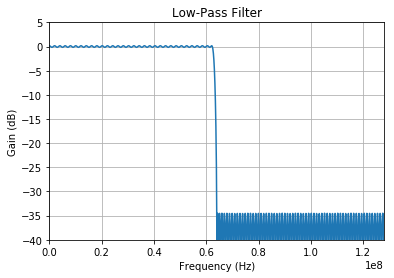

In [3]:
import math

fs = 256e6              # Sampling frequency (Hz)
bw = 64e6              # Choose bandwidth (Hz)
L = math.floor(fs/bw)   # Get the decimation factor
cutoff = fs/L-(fs/L)*0.025    # Cutoff frequency (Hz)
transition = fs/L*0.025   # Transition length (Hz)
number_taps = 256       # Number of taps in the FIR

# Generate a symmetric low-pass filter
w, h, coeffs = SAM.BandwidthSelector.generate_lowpass(fs, cutoff, transition, number_taps)

# Plot the frequency response
SAM.BandwidthSelector.plot_response(fs, w, h, title = "Low-Pass Filter")

<a class="anchor" id="window_selection"></a>
## 5. Window Selection
Performing an FFT on a finite number of samples, such as a frame, introduces an artefact called <b>Spectral Leakage</b>. This occurs because the signal’s behaviour outside of the captured frame is unknown and the FFT assumes that the signal repeats forever (where the captured frame represents one period). When capturing real signals, the frame will likely have discontinuities at either end. Sharp discontinuities have a large bandwidth which causes the signal’s frequency to be spread across the spectrum. 

To limit the effects of spectral leakage and smooth out the discontinuities, a <b>window</b> can be applied. Windows reduce the signal’s amplitude at either end of the frame in the time domain thereby reducing the discontinuities between ‘repeating’ frames. There are a number of different windows which can be applied to a signal. Each have their own characteristics and these must be considered for the particular application. Windows with a large mainlobe will decrease the frequency resolution of the signal, in constrast, windows with small side lobes will better reduce spectral leakage. 

The user interface below allows for a variety of windows to be applied. The coefficients are generated using <b>numpy</b> and can be inspected in both the time and frequency domain before applying them in hardware. 
When the Load button is clicked, the window coefficients are loaded into the hardware by the DMA and stored in Block RAM (BRAM). The window is applied by multiplying the stored coefficients with the incoming IQ frames. Any DC component that may have been introduced to the signal beforehand is suppressed by subtracting the mean value of each frame from every sample in the window. The figure below illustrates the window’s hardware design in the RFSoC's PL. 

<br>

<img src="assets/spectrum_window.png" alt="Drawing" style="width: 40%;" align="middle"/>

<br>

Upon <b>running</b> the cell below, an interface will allow you to select several pre-defined windows. First click your chosen window from the menu (its response will then appear in the plot) and click `Load` to apply the window to the incoming RF data stream.

In [4]:
SAM.WindowSetup()

Accordion(children=(VBox(children=(FigureWidget({
    'data': [{'marker': {'color': '#005d95'},
              …

<a class="anchor" id="receiver"></a>
## 7. The Receiver
To inspect the signal which is being transmitted from the DAC, the ADC must demodulate correctly. This is acheived using a numerically controlled oscillator (nco) which should produce the same frequnecy as the nco used to modulate the data in the DAC. Ensure that the center frequency specified below matches that of the transmitter. 

In [5]:
SAM.ReceiverSetup()

Accordion(children=(VBox(children=(Dropdown(description='ADC', layout=Layout(width='auto'), options=(0, 1, 2),…

<a class="anchor" id="spectrum_analysis"></a>
## 7. Spectrum Analysis
The RF spectrum can be analysed by applying an FFT to the window data. As illustrated in the figure below, the FFT creates frames of frequency magnitude data. The logarithmic domain can be used to improve the representation of this data. A floating-point hardware accelerated PSD and decibel conversion is applied at the output of the FFT. The data is then sent to the data inspector that locks on to the FFT's start-of-frame signal and initiates a transfer into the RFSoC's main memory using a DMA.

<br>

<img src="assets/spectrum_fft.png" alt="Drawing" style="width: 45%;" align="middle"/>

<br>

Individual frames of FFT data can be retrieved by calling `SAM.DataInspector.get_buffer_frame()`. This may be useful if you only one frame is required for analysis.

<a class="anchor" id="fft_viewer"></a>
### 7.1. FFT Viewer
We will now inspect the RF spectrum in real-time. Frames of FFT data can be visualised by plotting the incoming frames using Plotly graph objects. In particular, the `plotly.graph_objects.FigureWidget()` class is used to create an animated plot of the FFT data.

<b>Run</b> the cell below to setup the Spectrum Analyser and click the play button to begin inspecting the RF spectrum. You will notice that there are two sliders at the bottom of the graph. One will allow you to change the center frequency (fc) of the analyser, and the other will change the frequency resolution (Δf). Changing the frequency resolution will also cause the bandwidth of the analyser to change. A finer resolution will result in a smaller bandwidth, whilst a coarser resolution will result in a larger bandwidth.

<b>When you are finished, ensure you click the stop button to end the animation.</b>

<div style="background-color: #d9edf7; color: #31708f; padding: 15px;">
    <b>Tip:</b> It is possible to change the DMA polling and animation period using the arguments below to increase frame rate and improve the 'smoothness' of animation.
</div>

In [6]:
spec = SAM.SpectrumViewer(animation_period = 100, dma_period = 1/25, colourscale='jet')
display(spec.children[0].children[0])
display(spec.children[1])

FastFigureWidget({
    'data': [{'marker': {'color': '#005d95'},
              'type': 'scatter',
            …

<a class="anchor" id="waterfall_plot"></a>
### 7.2. Waterfall Plot (Spectogram)
A spectrogram allows for the frequency characteristics of a signal to be visualised as it varies with time. The plot below is created using the Heatmap functionality Plotly provides. The heatmap colour can be changed to a variety of colourscales. Predefined sequential colourscales can be found by first importing plotly and tab completing `plotly.express.colors.sequential`. More information about colourscales and how to create your own can be found here: https://plot.ly/python/colorscales/. 

<b>Run</b> the cell below to display the Spectorgram and click the `Enable Waterfall` box above (while the spectrum is running) to begin inspecting the RF spectrum through time.

<b>When you are finished, ensure you click the stop button to end the animation.</b>

In [7]:
spec.children[0].children[1]

FigureWidget({
    'data': [{'colorscale': [[0.0, 'rgb(0,0,131)'], [0.2, 'rgb(0,60,170)'], [0.4,
             …

<a class="anchor" id="summary"></a>
### 8. Summary

You have now experienced a flexible spectrum analyser performed entirely on the Zynq UltraScale+ RFSoC. This example has demonstrated the following:

* Heterogeneous processing using the RFSoC's PS and PL to acheive RF Spectrum Analysis
* Introspection of FFT data frames taken from the PL
* Animation of FFT data using Plotly libraries
    * PSD plot
    * Waterfall plot (Spectogram)
* Adaptive bandwidth control and center frequency selection
* Reprogrammable windowing